In [1]:
# %% [Evaluation Setup]
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# %% [Load Validation Set]
val_df = pd.read_json("phase1_val.jsonl", lines=True)

# %% [Prompt Construction]
def build_prompt(row):
    return f"""{row['instruction']}

Event: {row['input']}

Answer:"""

val_df["prompt"] = val_df.apply(build_prompt, axis=1)
true_labels = val_df["output"].tolist()

# %% [Load Quantized Base Model + Tokenizer]
model_name = "microsoft/Phi-3-mini-4k-instruct"
compute_dtype = torch.float16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

c:\Users\shiva\miniconda3\envs\finetune\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


In [2]:
model = PeftModel.from_pretrained(base_model, "trained-model")
model.eval()
model.config.use_cache = False  # <- THIS IS CRUCIAL

In [6]:
# %% [Prediction Loop]
preds = []

for prompt in tqdm(val_df["prompt"].tolist(), desc="Generating Predictions"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=False,
            use_cache=False,
            pad_token_id=tokenizer.pad_token_id
        )
        # print(outputs[0])
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    prediction = decoded.split("Answer:")[-1].strip().split("\n")[0]
    preds.append(prediction)

Generating Predictions: 100%|██████████| 143/143 [01:37<00:00,  1.46it/s]


✅ Accuracy: 0.7483

📊 Classification Report:

                    precision    recall  f1-score   support

             Death     0.8571    0.7500    0.8000        24
Device Malfunction     0.6761    0.8136    0.7385        59
            Injury     0.8039    0.6833    0.7387        60

          accuracy                         0.7483       143
         macro avg     0.7790    0.7490    0.7591       143
      weighted avg     0.7601    0.7483    0.7489       143



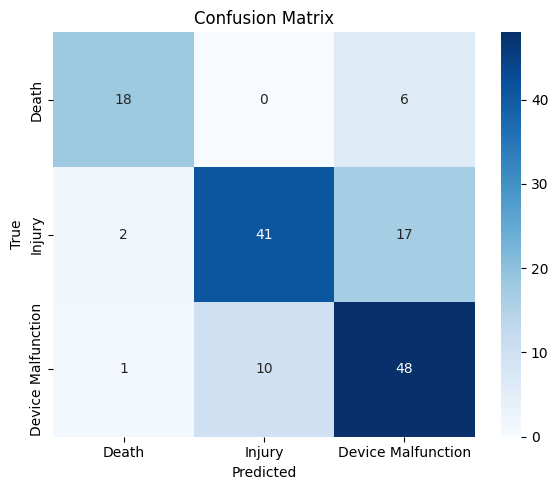

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add predictions to DataFrame
val_df["predicted_label"] = preds

# Ground truth and predictions
true_labels = val_df["output"].tolist()
pred_labels = val_df["predicted_label"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

# Confusion Matrix
labels = ["Death", "Injury", "Device Malfunction"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [9]:
val_df.to_csv("final_val.csv")

✅ Accuracy: 0.7483

📊 Classification Report:

                    precision    recall  f1-score   support

             Death     0.8571    0.7500    0.8000        24
Device Malfunction     0.6761    0.8136    0.7385        59
            Injury     0.8039    0.6833    0.7387        60

          accuracy                         0.7483       143
         macro avg     0.7790    0.7490    0.7591       143
      weighted avg     0.7601    0.7483    0.7489       143



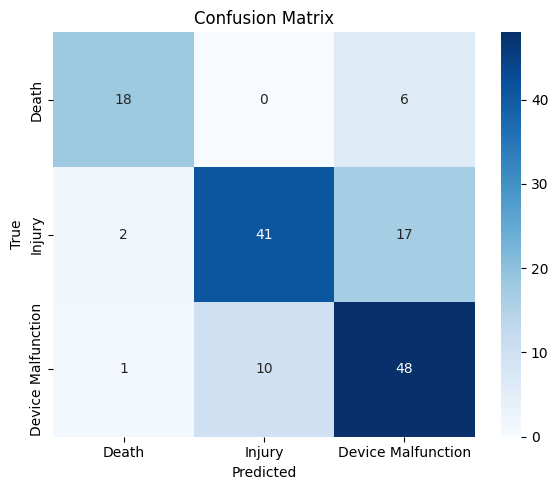

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ground truth
true_labels = val_df["output"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(true_labels, preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds, labels=["Death", "Injury", "Device Malfunction"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Death", "Injury", "Device Malfunction"],
            yticklabels=["Death", "Injury", "Device Malfunction"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Evaluate on test data from 2010 and 2009

In [2]:
import pandas as pd

In [5]:
data_2009=pd.read_csv("data_2009_50_summary.csv", index_col=0)

In [ ]:
# %% [Evaluation Setup]
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# %% [Load Validation Set]
val_df = pd.read_json("data_2009_test.jsonl", lines=True)

# %% [Prompt Construction]
def build_prompt(row):
    return f"""{row['instruction']}

Event: {row['input']}

Answer:"""

val_df["prompt"] = val_df.apply(build_prompt, axis=1)
true_labels = val_df["output"].tolist()

# %% [Load Quantized Base Model + Tokenizer]
model_name = "microsoft/Phi-3-mini-4k-instruct"
compute_dtype = torch.float16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

c:\Users\shiva\miniconda3\envs\finetune\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]


In [2]:
model = PeftModel.from_pretrained(base_model, "trained-model")
model.eval()
model.config.use_cache = False  # <- THIS IS CRUCIAL

In [12]:
# %% [Prediction Loop]
preds = []

for prompt in tqdm(val_df["prompt"].tolist(), desc="Generating Predictions"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=False,
            use_cache=False,
            pad_token_id=tokenizer.pad_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    prediction = decoded.split("Answer:")[-1].strip().split("\n")[0]
    preds.append(prediction)

Generating Predictions: 100%|██████████| 174/174 [01:55<00:00,  1.51it/s]


✅ Accuracy: 0.5287

📊 Classification Report:

                    precision    recall  f1-score   support

             Death     0.8444    0.6333    0.7238        60
Device Malfunction     0.4783    0.7586    0.5867        58
            Injury     0.2703    0.1786    0.2151        56

          accuracy                         0.5287       174
         macro avg     0.5310    0.5235    0.5085       174
      weighted avg     0.5376    0.5287    0.5144       174



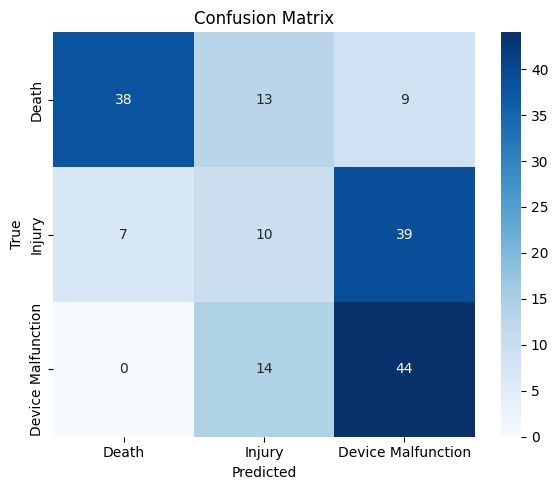

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add predictions to DataFrame
val_df["predicted_label"] = preds

# Ground truth and predictions
true_labels = val_df["output"].tolist()
pred_labels = val_df["predicted_label"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

# Confusion Matrix
labels = ["Death", "Injury", "Device Malfunction"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [14]:
val_df.to_csv("val_data_pred.csv")

✅ Accuracy: 0.5287

📊 Classification Report Test 2009 sample data:

                    precision    recall  f1-score   support

             Death     0.8444    0.6333    0.7238        60
Device Malfunction     0.4783    0.7586    0.5867        58
            Injury     0.2703    0.1786    0.2151        56

          accuracy                         0.5287       174
         macro avg     0.5310    0.5235    0.5085       174
      weighted avg     0.5376    0.5287    0.5144       174



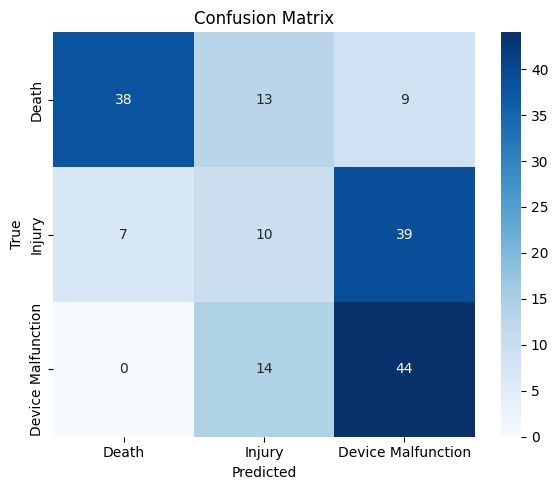

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ground truth
true_labels = val_df["output"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report Test 2009 sample data:\n")
print(classification_report(true_labels, preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds, labels=["Death", "Injury", "Device Malfunction"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Death", "Injury", "Device Malfunction"],
            yticklabels=["Death", "Injury", "Device Malfunction"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [10]:
# %% [Load Validation Set]
val_df = pd.read_json("data_2009_test_foi.jsonl", lines=True)

# %% [Prompt Construction]
def build_prompt(row):
    return f"""{row['instruction']}

Event: {row['input']}

Answer:"""

val_df["prompt"] = val_df.apply(build_prompt, axis=1)
true_labels = val_df["output"].tolist()

In [11]:
# %% [Prediction Loop]
preds = []

for prompt in tqdm(val_df["prompt"].tolist(), desc="Generating Predictions"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=False,
            use_cache=False,
            pad_token_id=tokenizer.pad_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    prediction = decoded.split("Answer:")[-1].strip().split("\n")[0]
    preds.append(prediction)

Generating Predictions: 100%|██████████| 174/174 [02:49<00:00,  1.02it/s]


✅ Accuracy: 0.5115

📊 Classification Report Test 2009 sample data:

                    precision    recall  f1-score   support

             Death     0.8684    0.5500    0.6735        60
Device Malfunction     0.4495    0.8448    0.5868        58
            Injury     0.2593    0.1250    0.1687        56

          accuracy                         0.5115       174
         macro avg     0.5257    0.5066    0.4763       174
      weighted avg     0.5327    0.5115    0.4821       174



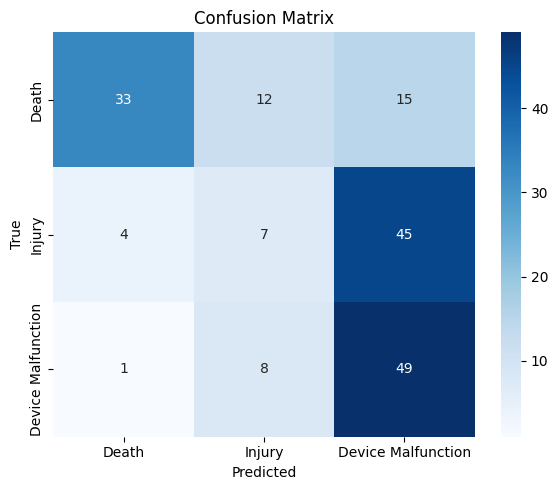

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ground truth
true_labels = val_df["output"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report Test 2009 sample data:\n")
print(classification_report(true_labels, preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds, labels=["Death", "Injury", "Device Malfunction"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Death", "Injury", "Device Malfunction"],
            yticklabels=["Death", "Injury", "Device Malfunction"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# test on base model

In [15]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


In [16]:
model = base_model
model.eval()
model.config.use_cache = False


In [17]:
preds = []
for prompt in tqdm(val_df["prompt"], desc="Base Model Predictions"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=False,
            use_cache=False,
            pad_token_id=tokenizer.pad_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    prediction = decoded.split("Answer:")[-1].strip().split("\n")[0]
    preds.append(prediction)


Base Model Predictions: 100%|██████████| 174/174 [13:42<00:00,  4.72s/it]


✅ Accuracy: 0.3736

📊 Classification Report Base Model Test 2009 sample data:

                                                                                                       precision    recall  f1-score   support

                                                                                                Death     0.9333    0.2333    0.3733        60
                                                                                   Device Malfunction     0.5165    0.8103    0.6309        58
                                                                                               Injury     0.2222    0.0714    0.1081        56
             The adverse event described can be classified as Death. The event involves a patient who     0.0000    0.0000    0.0000         0
            The adverse event described can be classified as Death. The event involves a serious comp     0.0000    0.0000    0.0000         0
                       The adverse event described can be clas

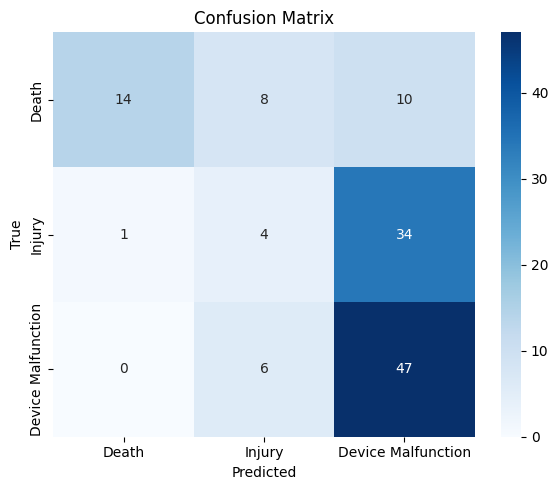

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ground truth
true_labels = val_df["output"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report Base Model Test 2009 sample data:\n")
print(classification_report(true_labels, preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds, labels=["Death", "Injury", "Device Malfunction"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Death", "Injury", "Device Malfunction"],
            yticklabels=["Death", "Injury", "Device Malfunction"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
